In [1]:
import tensorflow as tf
import os
import pathlib
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

In [2]:
# 定义数据集路径
DATASET_PATH = 'data'
data_dir = pathlib.Path(DATASET_PATH)

# 下载并解压数据集
if not data_dir.exists():
    tf.keras.utils.get_file(
        'speech_commands_v0.02.tar.gz',
        origin='http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz',
        extract=True, cache_dir='.', cache_subdir='data')

# 确认解压后的实际路径
extracted_dir = pathlib.Path('./data')
if not extracted_dir.exists():
    print(f"数据集解压路径 {extracted_dir} 不存在。请检查路径是否正确。")
else:
    print(f"数据集解压路径 {extracted_dir} 已确认存在。")

# 如果解压路径不存在，检查解压路径的具体内容
if not extracted_dir.exists():
    data_root = pathlib.Path('./data/')
    print("Available directories after extraction:")
    for item in data_root.iterdir():
        print(item)

# 确认实际路径
commands = np.array([f.name for f in data_dir.glob('*') if f.is_dir() and f.name != '_background_noise_' and not f.name.startswith('.')])
print('Commands:', commands)

数据集解压路径 data 已确认存在。
Commands: ['backward' 'bed' 'bird' 'cat' 'dog' 'down' 'eight' 'five' 'follow'
 'forward' 'four' 'go' 'happy' 'house' 'learn' 'left' 'marvin' 'nine' 'no'
 'off' 'on' 'one' 'right' 'seven' 'sheila' 'six' 'stop' 'three' 'tree'
 'two' 'up' 'visual' 'wow' 'yes' 'zero']


In [3]:
# 定义音频加载和预处理函数
def decode_audio(audio_binary):
    audio, _ = tf.audio.decode_wav(audio_binary)
    return tf.squeeze(audio, axis=-1)

def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2]

def get_waveform_and_label(file_path):
    audio_binary = tf.io.read_file(file_path)
    waveform = decode_audio(audio_binary)
    label = get_label(file_path)
    return waveform, label

def get_spectrogram(waveform):
    spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
    spectrogram = tf.abs(spectrogram)
    return spectrogram

def pad_waveform(waveform, max_length=16000):
    waveform = waveform[:max_length]
    zero_padding = tf.zeros([max_length] - tf.shape(waveform), dtype=tf.float32)
    waveform = tf.concat([waveform, zero_padding], 0)
    return waveform

def get_spectrogram_and_label_id(audio, label):
    audio = pad_waveform(audio)
    spectrogram = get_spectrogram(audio)
    spectrogram = tf.expand_dims(spectrogram, -1)
    label_id = tf.argmax(label == commands)
    return spectrogram, label_id

def preprocess_dataset(files):
    files_ds = tf.data.Dataset.from_tensor_slices(files)
    output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=tf.data.AUTOTUNE)
    output_ds = output_ds.map(get_spectrogram_and_label_id, num_parallel_calls=tf.data.AUTOTUNE)
    return output_ds

In [4]:
# 加载文件路径
filenames = tf.io.gfile.glob(str(extracted_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of samples:', num_samples)

# 划分数据集
train_files = filenames[:int(0.8 * num_samples)]
val_files = filenames[int(0.8 * num_samples):int(0.9 * num_samples)]
test_files = filenames[int(0.9 * num_samples):]

# 预处理数据集
train_ds = preprocess_dataset(train_files)
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

# 批处理并缓存数据集
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

train_ds = train_ds.cache().prefetch(tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(tf.data.AUTOTUNE)

Number of samples: 105835


In [5]:
class SparseConv2D(layers.Layer):
    def __init__(self, filters, kernel_size, p, **kwargs):
        super(SparseConv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.p = tf.Variable(float(p), trainable=False)  # 将 p 转换为浮点数类型
        self.counter = tf.Variable(0, trainable=False, dtype=tf.int32)  # 初始化计数器

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(self.kernel_size, self.kernel_size, input_shape[-1], self.filters),
                                      initializer='glorot_uniform',
                                      trainable=True)
        self.bias = self.add_weight(name='bias',
                                    shape=(self.filters,),
                                    initializer='zeros',
                                    trainable=True)

    @tf.function
    def call(self, inputs, training=None):
        if training:
            mask = tf.random.uniform(shape=(self.filters,), minval=0, maxval=1)
            mask = tf.cast(mask < self.p, dtype=tf.float32)
            mask = tf.reshape(mask, [1, 1, 1, self.filters])
            #self.counter.assign_add(1)  # 更新计数器
            #tf.print("\nP is", self.p)  # 使用 tf.print
        else:
            mask = tf.ones([1, 1, 1, self.filters], dtype=tf.float32) * self.p
    
        sparse_kernel = self.kernel * mask
        conv = tf.nn.conv2d(inputs, sparse_kernel, strides=[1, 1, 1, 1], padding='SAME')
        return tf.nn.bias_add(conv, self.bias)

    @tf.function
    def update_p(self, new_p):
        self.p.assign(float(new_p))  # 使用 assign 更新 tf.Variable 的值，并转换为浮点数
        #tf.print("\nEpoch counter is", self.counter)  # 使用 tf.print
        #tf.print("\nP is", self.p)  # 使用 tf.print

In [6]:
# 定义模型
def build_model(input_shape, num_classes):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        SparseConv2D(filters=128, kernel_size=3, p=1, name='sparse_conv2d_3'),
        layers.Activation('relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])
    return model

input_shape = (124, 129, 1)
num_classes = len(commands)
model = build_model(input_shape, num_classes)

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 122, 127, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 61, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 59, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 30, 64)       0         
 2D)                                                             
                                                                 
 sparse_conv2d_3 (SparseConv  (None, 29, 30, 128)      73858     
 2D)                                                             
                                                        

In [7]:
class UpdatePSparsity(tf.keras.callbacks.Callback):
    def __init__(self, model, sparsity_schedule):
        super(UpdatePSparsity, self).__init__()
        self.model = model
        self.sparsity_schedule = sparsity_schedule

    def on_epoch_end(self, epoch, logs=None):
        for layer_name, new_p in self.sparsity_schedule.items():
            layer = self.model.get_layer(name=layer_name)
            if epoch < len(new_p):
                p_value = new_p[epoch]
            else:
                p_value = new_p[-1]  # Use the last value for epochs beyond the predefined ones
            layer.update_p(p_value)
            #print(f"\nEpoch {epoch + 1}: Updated layer {layer_name} sparsity p to {p_value}")

sparsity_schedule = {
    'sparse_conv2d_3': [0.9,0.7,0.5]
}

Epoch 1/20
1323/1323 [==============================] - 21s 15ms/step - loss: 1.0336 - accuracy: 0.7172 - val_loss: 0.5398 - val_accuracy: 0.8432
Epoch 2/20
1323/1323 [==============================] - 16s 12ms/step - loss: 0.4192 - accuracy: 0.8774 - val_loss: 0.4853 - val_accuracy: 0.8591
Epoch 3/20
1323/1323 [==============================] - 16s 12ms/step - loss: 0.3617 - accuracy: 0.8900 - val_loss: 0.4622 - val_accuracy: 0.8684
Epoch 4/20
1323/1323 [==============================] - 15s 11ms/step - loss: 0.3893 - accuracy: 0.8817 - val_loss: 0.4193 - val_accuracy: 0.8759
Epoch 5/20
1323/1323 [==============================] - 15s 11ms/step - loss: 0.3288 - accuracy: 0.8999 - val_loss: 0.4205 - val_accuracy: 0.8777
Epoch 6/20
1323/1323 [==============================] - 16s 12ms/step - loss: 0.2907 - accuracy: 0.9102 - val_loss: 0.4218 - val_accuracy: 0.8871
Epoch 7/20
1323/1323 [==============================] - 17s 13ms/step - loss: 0.2628 - accuracy: 0.9185 - val_loss: 0.4115 -

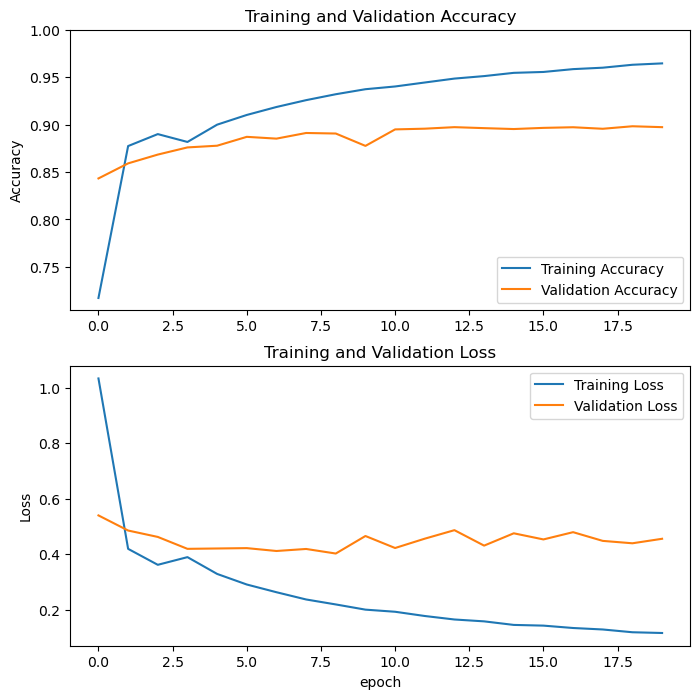

In [8]:
# 训练模型
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=[UpdatePSparsity(model, sparsity_schedule)])

# 评估模型
test_loss, test_acc = model.evaluate(test_ds)
print('Test accuracy:', test_acc)

# 可视化训练过程
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()